In [1]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!cd /home
!pwd

/home/ai4-code/code


In [5]:
!kaggle competitions download -c AI4Code

100%|████████████████████████████████████████| 714M/714M [01:06<00:00, 14.7MB/s]
100%|████████████████████████████████████████| 714M/714M [01:06<00:00, 11.3MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('AI4Code.zip', 'r')
zip_ref.extractall('/home/input/AI4Code')
zip_ref.close()


In [9]:
!nvidia-smi

Tue Jul 12 10:38:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1C:00.0 Off |                  Off |
| 33%   26C    P8     3W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

139256it [00:06, 20390.32it/s]


only one: 118529


139256it [00:06, 20326.15it/s]


good notebooks 118529


Train NBs: 100%|██████████| 100/100 [00:00<00:00, 211.45it/s]


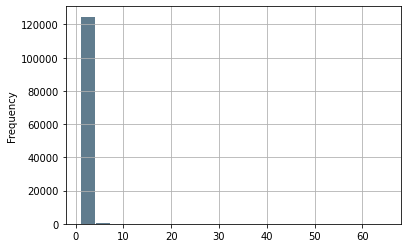

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from tqdm import tqdm
from pathlib import Path

import time

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

def is_interactive_mode():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Interactive') == 'Interactive'

data_dir = Path('/home/input/AI4Code')


df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
# df_ancestors =df_ancestors.head(1000)
# TODO: rewrite this to use the dataframe

cnt_by_group = {}
for id, row in tqdm(df_ancestors.iterrows()):
    cnt_by_group[row['ancestor_id']] = cnt_by_group.get(row['ancestor_id'], 0) + 1


cnt = pd.Series(cnt_by_group)
print('only one:', cnt[cnt == 1].count())
cnt.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
cnt

good_notebooks = []
for id, row in tqdm(df_ancestors.iterrows()):
    if row['parent_id'] != None and cnt_by_group[row['ancestor_id']] == 1:
        good_notebooks.append(id)

good_notebooks = pd.Series(good_notebooks)
print('good notebooks', len(good_notebooks))

all_train_nb = good_notebooks.sample(frac=0.9, random_state=787788)
all_validate_nb = good_notebooks.drop(all_train_nb.index)

def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )

def load_train_nbs(num):
    global df

    paths_train = [data_dir / 'train' / '{}.json'.format(id) for id in all_train_nb.head(num)]
    notebooks_train = [
        read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
    ]
    df = (
        pd.concat(notebooks_train)
        .set_index('id', append=True)
        .swaplevel()
        .sort_index(level='id', sort_remaining=False)
    )

    df
    
load_train_nbs(100)

def get_example_nb_id(seed=0):
    return df.index.get_level_values(0).unique()[seed]
    
nb_id = get_example_nb_id()

def get_nb_by_id(nb_id):
    return df.loc[nb_id]

def get_example_cell_from_nb(nb):
    return nb.index[0]

def get_example_markdown_cell_from_nb(nb):
    return nb[nb['cell_type'] == 'markdown'].index[0]

def get_code_cells(nb):
    return nb[nb['cell_type'] == 'code'].index

def get_markdown_cells(nb):
    return nb[nb['cell_type'] == 'markdown'].index    

In [14]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 1.0 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 1.4 MB/s eta 0:00:0000:0100:01


In [15]:
# Copied from: https://github.com/microsoft/CodeBERT/blob/master/UniXcoder/unixcoder.py

# Copyright (c) Microsoft Corporation. 
# Licensed under the MIT license.

import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig

class UniXcoder(nn.Module):
    def __init__(self, model_name, state_dict=None):
        """
            Build UniXcoder.
            Parameters:
            * `model_name`- huggingface model card name. e.g. microsoft/unixcoder-base
        """        
        super(UniXcoder, self).__init__()
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.config = RobertaConfig.from_pretrained(model_name)
        self.config.is_decoder = True
        self.model = RobertaModel.from_pretrained(model_name, config=self.config)

        if state_dict is not None:
            self.model.load_state_dict(torch.load(state_dict))   
        
        self.register_buffer("bias", torch.tril(torch.ones((1024, 1024), dtype=torch.uint8)).view(1,1024, 1024))
        self.lm_head = nn.Linear(self.config.hidden_size, self.config.vocab_size, bias=False)
        self.lm_head.weight = self.model.embeddings.word_embeddings.weight
        self.lsm = nn.LogSoftmax(dim=-1)
        
        self.tokenizer.add_tokens(["<mask0>"],special_tokens=True)
        #self.tokenizer.add_tokens(["<END>"], special_tokens=True)
          
    def tokenize(self, inputs, mode="<encoder-only>", max_length=512, padding=False):
        """ 
        Convert string to token ids 
                
        Parameters:
        * `inputs`- list of input strings.
        * `max_length`- The maximum total source sequence length after tokenization.
        * `padding`- whether to pad source sequence length to max_length. 
        * `mode`- which mode the sequence will use. i.e. <encoder-only>, <decoder-only>, <encoder-decoder>
        """
        assert mode in ["<encoder-only>", "<decoder-only>", "<encoder-decoder>"]
        
        tokenizer = self.tokenizer
        
        tokens_ids = []
        for x in inputs:
            tokens = tokenizer.tokenize(x)
            if mode == "<encoder-only>":
                tokens = tokens[:max_length-4]
                tokens = [tokenizer.cls_token,mode,tokenizer.sep_token] + tokens + [tokenizer.sep_token]                
            elif mode == "<decoder-only>":
                tokens = tokens[-(max_length-3):]
                tokens = [tokenizer.cls_token,mode,tokenizer.sep_token] + tokens
            else:
                tokens = tokens[:max_length-5]
                tokens = [tokenizer.cls_token,mode,tokenizer.sep_token] + tokens + [tokenizer.sep_token]
                
            tokens_id = tokenizer.convert_tokens_to_ids(tokens)
            tokens_ids.append(tokens_id)

        if padding:
            cur_max_length = len(max(tokens_ids, key=len))
            tokens_ids = list(map(lambda l: l + [self.config.pad_token_id] * (cur_max_length-len(l)), tokens_ids))
        return tokens_ids
            
    def decode(self, source_ids):   
        """ Convert token ids to string """      
        predictions = []
        for x in source_ids:
            prediction = []
            for y in x:
                t = y.cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = self.tokenizer.decode(t,clean_up_tokenization_spaces=False)
                prediction.append(text)        
            predictions.append(prediction)
        return predictions
    
    def forward(self, source_ids):   
        """ Obtain token embeddings and sentence embeddings """
        mask = source_ids.ne(self.config.pad_token_id)
        token_embeddings = self.model(source_ids,attention_mask = mask.unsqueeze(1) * mask.unsqueeze(2))[0]
        sentence_embeddings = (token_embeddings * mask.unsqueeze(-1)).sum(1) / mask.sum(-1).unsqueeze(-1)
        return token_embeddings, sentence_embeddings       

    def generate(self, source_ids, decoder_only = True, eos_id = None, beam_size = 5, max_length = 64):
        """ Generate sequence given context (source_ids) """
        
        # Set encoder mask attention matrix: bidirectional for <encoder-decoder>, unirectional for <decoder-only>
        if decoder_only:
            mask = self.bias[:,:source_ids.size(-1),:source_ids.size(-1)]
        else:
            mask = source_ids.ne(self.config.pad_token_id)
            mask = mask.unsqueeze(1) * mask.unsqueeze(2)  
            
        if eos_id is None:
            eos_id = self.config.eos_token_id
        
        device = source_ids.device
        
        # Decoding using beam search
        preds = []       
        zero = torch.LongTensor(1).fill_(0).to(device)   
        source_len = list(source_ids.ne(1).sum(-1).cpu().numpy())
        length = source_ids.size(-1)
        encoder_output = self.model(source_ids,attention_mask=mask)
        for i in range(source_ids.shape[0]):
            context = [[x[i:i+1,:,:source_len[i]].repeat(beam_size,1,1,1) for x in y] 
                     for y in encoder_output.past_key_values]
            beam = Beam(beam_size,eos_id,device)
            input_ids = beam.getCurrentState().clone()
            context_ids = source_ids[i:i+1,:source_len[i]].repeat(beam_size,1)
            out = encoder_output.last_hidden_state[i:i+1,:source_len[i]].repeat(beam_size,1,1)
            for _ in range(max_length): 
                if beam.done():
                    break
                if _ == 0: 
                    hidden_states = out[:,-1,:]
                    out = self.lsm(self.lm_head(hidden_states)).data
                    beam.advance(out)
                    input_ids.data.copy_(input_ids.data.index_select(0, beam.getCurrentOrigin()))
                    input_ids = beam.getCurrentState().clone()
                else:
                    length = context_ids.size(-1)+input_ids.size(-1)
                    out = self.model(input_ids,attention_mask=self.bias[:,context_ids.size(-1):length,:length],
                                       past_key_values=context).last_hidden_state
                    hidden_states = out[:,-1,:]
                    out = self.lsm(self.lm_head(hidden_states)).data
                    beam.advance(out)
                    input_ids.data.copy_(input_ids.data.index_select(0, beam.getCurrentOrigin()))
                    input_ids = torch.cat((input_ids,beam.getCurrentState().clone()),-1)
            hyp = beam.getHyp(beam.getFinal())
            pred = beam.buildTargetTokens(hyp)[:beam_size]
            pred = [torch.cat([x.view(-1) for x in p]+[zero]*(max_length-len(p))).view(1,-1) for p in pred]
            preds.append(torch.cat(pred,0).unsqueeze(0))

        preds = torch.cat(preds,0)    

        return preds  
    

    
class Beam(object):
    def __init__(self, size, eos, device):
        self.size = size
        self.device = device
        # The score for each translation on the beam.
        self.scores = torch.FloatTensor(size).zero_().to(device)
        # The backpointers at each time-step.
        self.prevKs = []
        # The outputs at each time-step.
        self.nextYs = [torch.LongTensor(size).fill_(0).to(device)]
        # Has EOS topped the beam yet.
        self._eos = eos
        self.eosTop = False
        # Time and k pair for finished.
        self.finished = []

    def getCurrentState(self):
        "Get the outputs for the current timestep."
        batch = self.nextYs[-1].view(-1, 1)
        return batch

    def getCurrentOrigin(self):
        "Get the backpointers for the current timestep."
        return self.prevKs[-1]

    def advance(self, wordLk):
        """
        Given prob over words for every last beam `wordLk` and attention
        `attnOut`: Compute and update the beam search.
        Parameters:
        * `wordLk`- probs of advancing from the last step (K x words)
        * `attnOut`- attention at the last step
        Returns: True if beam search is complete.
        """
        numWords = wordLk.size(1)

        # Sum the previous scores.
        if len(self.prevKs) > 0:
            beamLk = wordLk + self.scores.unsqueeze(1).expand_as(wordLk)

            # Don't let EOS have children.
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] == self._eos:
                    beamLk[i] = -1e20
        else:
            beamLk = wordLk[0]
        flatBeamLk = beamLk.view(-1)
        bestScores, bestScoresId = flatBeamLk.topk(self.size, 0, True, True)

        self.scores = bestScores

        # bestScoresId is flattened beam x word array, so calculate which
        # word and beam each score came from
        prevK = bestScoresId // numWords
        self.prevKs.append(prevK)
        self.nextYs.append((bestScoresId - prevK * numWords))


        for i in range(self.nextYs[-1].size(0)):
            if self.nextYs[-1][i] == self._eos:
                s = self.scores[i]
                self.finished.append((s, len(self.nextYs) - 1, i))

        # End condition is when top-of-beam is EOS and no global score.
        if self.nextYs[-1][0] == self._eos:
            self.eosTop = True

    def done(self):
        return self.eosTop and len(self.finished) >= self.size

    def getFinal(self):
        if len(self.finished) == 0:
            self.finished.append((self.scores[0], len(self.nextYs) - 1, 0))
        self.finished.sort(key=lambda a: -a[0])
        if len(self.finished) != self.size:
            unfinished=[]
            for i in range(self.nextYs[-1].size(0)):
                if self.nextYs[-1][i] != self._eos:
                    s = self.scores[i]
                    unfinished.append((s, len(self.nextYs) - 1, i)) 
            unfinished.sort(key=lambda a: -a[0])
            self.finished+=unfinished[:self.size-len(self.finished)]
        return self.finished[:self.size]

    def getHyp(self, beam_res):
        """
        Walk back to construct the full hypothesis.
        """
        hyps=[]
        for _,timestep, k in beam_res:
            hyp = []
            for j in range(len(self.prevKs[:timestep]) - 1, -1, -1):
                hyp.append(self.nextYs[j+1][k])
                k = self.prevKs[j][k]
            hyps.append(hyp[::-1])
        return hyps
    
    def buildTargetTokens(self, preds):
        sentence=[]
        for pred in preds:
            tokens = []
            for tok in pred:
                if tok==self._eos:
                    break
                tokens.append(tok)
            sentence.append(tokens)
        return sentence
        

In [17]:
import torch

def reload_model(preload_from_input=False, preload_from_working=False):
    global unixcoder_model
    global device
    default_model_name = "/home/unixcoderbase"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_pretrained = True
    state_dict = None
    if preload_from_input:
        print("Preloading from input...")
        state_dict = "../input/ai4code-pre1000/model-1000.bin" 
    if preload_from_working:
        print("Preloading from working copy...")
        state_dict = "../working/model-final.bin"
    unixcoder_model = UniXcoder(model_name=default_model_name, state_dict=state_dict)
    unixcoder_model.to(device)

reload_model()

In [18]:
tokenizer = unixcoder_model.tokenizer
# display(tokenizer)
seq = tokenizer.tokenize("https://google.com")
print(seq)
tokenizer.convert_tokens_to_ids(seq)

['https', '://', 'google', '.', 'com']


[4192, 1694, 4591, 132, 954]

In [20]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
).squeeze("columns").str.split()  # Split the string representation of cell_ids into a list

In [21]:
@torch.no_grad()
def get_embedding(nb, cell_id):
    start = time.time()
    cell = nb.loc[cell_id]
    tokens = unixcoder_model.tokenize([cell['source']],max_length=512,mode="<encoder-only>")
    source_ids = torch.tensor(tokens).to(device)
    _,embeddings = unixcoder_model(source_ids)
    return torch.nn.functional.normalize(embeddings, p=2, dim=1)[0].cpu()

In [22]:
def get_text_tokens(text):
    tokens = unixcoder_model.tokenize([text],max_length=512,mode="<encoder-only>")
    return torch.tensor(tokens).to(device)

def get_texts_tokens(texts):
    tokens = unixcoder_model.tokenize(texts,max_length=512,mode="<encoder-only>", padding=True)
    return torch.tensor(tokens).to(device)
    

def get_text_embedding(text):
    source_ids = get_text_tokens(text)
    _,embeddings = unixcoder_model(source_ids)
    return torch.nn.functional.normalize(embeddings, p=2, dim=1).cpu()[0]
    
get_texts_tokens(['END'])

tensor([[   0,    6,    2, 2553,    2]], device='cuda:0')

In [23]:
@torch.no_grad()
def get_nb_embeddings(nb):
    start = time.time()

    res = {}

#     TODO: maybe different size?
    batch_size = 8
    n_chunks = len(nb) / min(len(nb), batch_size)

    nb = nb.sort_values(by="source", key=lambda x: x.str.len())
    for nb in np.array_split(nb, n_chunks):
        # TODO: different max_length?
        tokens = unixcoder_model.tokenize(nb['source'].to_numpy(),max_length=512,mode="<encoder-only>", padding=True)
        source_ids = torch.tensor(tokens).to(device)
        _,embeddings = unixcoder_model(source_ids)
        normalized = torch.nn.functional.normalize(embeddings, p=2, dim=1).cpu()

        
        for key, val in zip(nb['source'].index, normalized):
            res[key] = val
    
    return res


In [24]:
def get_source(cell_id):
    return nb.loc[cell_id]['source']

def sim(emb1, emb2):
    return torch.einsum("i,i->", emb1, emb2).detach().numpy()

In [25]:
from bisect import bisect


# Actually O(N^2), but fast in practice for our data
def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):  # O(N)
        j = bisect(sorted_so_far, u)  # O(log N)
        inversions += i - j
        sorted_so_far.insert(j, u)  # O(N)
    return inversions

def kendall_tau(ground_truth, predictions):
    total_inversions = 0  # total inversions in predicted ranks across all instances
    total_2max = 0  # maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return [1 - 4 * total_inversions / total_2max, total_inversions, total_2max]

def sum_scores(a, b):
    total_inversions = a[1] + b[1]
    total_2max = a[2] + b[2]
    return [1 - 4 * total_inversions / total_2max, total_inversions, total_2max]

paths_test = list((data_dir / 'test').glob('*.json'))
notebooks_test = [
    read_notebook(path) for path in tqdm(paths_test, desc='Test NBs')
]
test_df = (
    pd.concat(notebooks_test)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

Test NBs: 100%|██████████| 4/4 [00:00<00:00, 131.43it/s]


In [26]:
@torch.no_grad()
def find_best_cell_order2(nb):
    code_cells = nb[nb['cell_type'] == 'code'].reset_index(level='cell_id')
    markdown_cells = nb[nb['cell_type'] != 'code'].reset_index(level='cell_id')
    
    embeddings = get_nb_embeddings(nb)
    
    code_cell_ids = code_cells['cell_id'].values
    
    order = code_cell_ids.tolist()    
    
    for m_cell_id in markdown_cells['cell_id'].values:
        markdown_emb = embeddings[m_cell_id]
        best_code = None
        best_score = -123456.0
        
        for c_cell_id in code_cell_ids:
            code_emb = embeddings[c_cell_id]
            cur_sim = sim(markdown_emb, code_emb)
            if cur_sim > best_score:
                best_score = cur_sim
                best_code = c_cell_id
        
        index = order.index(best_code)
        order.insert(index, m_cell_id)
        
    return order

def score_answer(nb_id, order):
    ground_truth = [df_orders[nb_id]]
    predictions = [order]

    return kendall_tau(ground_truth, predictions)

def get_random_test_nb_ids(n, random_state=1):
    return df.reset_index(level='cell_id').sample(n=n, random_state=random_state).index.values.tolist()

def calc_nb_score(nb_id):
    return score_answer(nb_id, find_best_cell_order2(df.loc[nb_id]))

def save_results():
    res = []

    for id_, notebook in test_df.groupby(level="id"):
        order = find_best_cell_order2(notebook.reset_index(level='id'))
        order = " ".join(order)
        
        res.append({'id' : id_, 'cell_order' : order})
        
    
    res = pd.DataFrame(res)
    res.to_csv('submission.csv', index=False)

    display(res.head())
    
def get_tokens(text):
    return unixcoder_model.tokenize([text],max_length=512,mode="<encoder-only>")    

In [27]:
# Partially coied from: https://github.com/microsoft/CodeBERT/blob/567dd49a4b916835f93fb95709de714b8772fea2/UniXcoder/downstream-tasks/code-search/model.py

# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.
import torch.nn as nn
import torch    
class Model(nn.Module):   
    def __init__(self, encoder):
        super(Model, self).__init__()
        self.encoder = encoder
      
    def forward(self, inputs): 
        outputs = self.encoder(inputs)[1]
        return torch.nn.functional.normalize(outputs, p=2, dim=1)

In [28]:
def save_model(model, suffix):
    #output_dir = Path("../working/")                       
    output_dir = Path(".")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)   
    model_to_save = model.encoder.model
    output_dir = os.path.join(output_dir, 'model-{}.bin'.format(suffix)) 
    torch.save(model_to_save.state_dict(), output_dir)
    print("Saved model to {}".format(output_dir))

In [29]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.3/146.3 kB 32.2 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=70d6780baafaeeb1796b4bd18d231f72386146bff5f3bf9a7d38f5da38bee76c
  Stored in directory: /home/.cache/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=2631c7c62f632b1943414f50d570d40113d9589fc54968279eba666ae7d91613
  Stored in directory: /home/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built promise pathtools


In [30]:
import wandb
import os


wb_key = open("/home/wandb_key", "r").read()

wandb.login(key=wb_key)


def init_wandb(name, config={}):
    is_interactive = "-interactive" if is_interactive_mode() else ""
    config=config.copy()
    config['name']='Train'
    
    wandb.init(project="ai4code", name=(name+is_interactive+"jarvis"), config=config)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/.netrc


In [31]:
import nltk
nltk.download('omw-1.4')

import numpy as np
import pandas as pd
import os
import re
# import fasttext
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from pathlib import Path
import nltk
nltk.download('wordnet')

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

preprocess_text("hello world !!11 here is a link http://google.com")

[nltk_data] Downloading package omw-1.4 to /home/nltk_data...
[nltk_data] Downloading package wordnet to /home/nltk_data...


'hello world here link http google'

In [32]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=5cb5d37c025bd01ec3abbd3e453692ca6ca494668c2f67d1ceb24f08423c5bf4
  Stored in directory: /home/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [33]:
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

from langdetect import detect

def detect_lang(x):
  try:
    return detect(x)
  except:
    return 'other'

add_end_token = True
end_token = 'END'


def train_on_nb(nb_id, model, optimizer, scheduler):
    nb = get_nb_by_id(nb_id)
    code_cell_ids = get_code_cells(nb).tolist()
    code_cell_ids.append(end_token)
    
    markdown_cell_ids = get_markdown_cells(nb)
    train_markdown_cell_ids = []
    for cell_id in markdown_cell_ids:
      text = nb.loc[cell_id]['source']
      # if detect_lang(text) == 'en':
      train_markdown_cell_ids.append(cell_id)

    correct_order = df_orders.loc[nb_id]
    if add_end_token:
        correct_order.append(end_token)
    
    next_code_cell = {}
    for i in range(len(correct_order)):
        if correct_order[i] in markdown_cell_ids:
            next_code_cell[correct_order[i]] = None
            for j in range(i+1, len(correct_order)):
                if correct_order[j] in code_cell_ids:
                    next_code_cell[correct_order[i]] = correct_order[j]
                    break
            

    batch_size = 8
    num_chunks = (len(train_markdown_cell_ids) + batch_size - 1) // batch_size
    
    sum_loss = 0.0

    if len(train_markdown_cell_ids) == 0:
      return 0.0
    
    for batch_markdown_cell_ids in np.array_split(train_markdown_cell_ids, num_chunks):
        batch_code_cells = []
        for markdown_cell_id in batch_markdown_cell_ids:
            need_cell = next_code_cell[markdown_cell_id]
            if need_cell is not None and need_cell not in batch_code_cells:
                batch_code_cells.append(need_cell)
        
        if len(batch_code_cells) == 0:
            continue;
            
        def get_code_source(cell_id):
            if cell_id == end_token:
                return end_token
            return nb.loc[cell_id]['source']

        
        def get_mark_source(cell_id):
            if cell_id == end_token:
                return end_token
            return nb.loc[cell_id]['source']

        code_tokens = get_texts_tokens([get_code_source(cell_id) for cell_id in batch_code_cells])
        markdown_tokens = get_texts_tokens([get_mark_source(cell_id) for cell_id in batch_markdown_cell_ids])

        code_vec = model(code_tokens)
        markdown_vec = model(markdown_tokens)
        scores = torch.einsum("ab,cb->ac", markdown_vec, code_vec) * 1000.0

        expected_order = []
        for cell_id in batch_markdown_cell_ids:
            if next_code_cell[cell_id] is None:
                assert not add_end_token
                expected_order.append(-100)
            else:
                expected_order.append(batch_code_cells.index(next_code_cell[cell_id]))

        expected_order = torch.tensor(expected_order).to(device)
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(scores, expected_order)
        
        sum_loss = sum_loss + loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step() 
    return sum_loss / num_chunks


from torch.optim import AdamW

    
    
# for seed in tqdm(range(steps)):    
#     run_train(seed)


def run_train_all():
    reload_model()
    model = Model(unixcoder_model)
    model.zero_grad()
    model.train()

    all = df.index.get_level_values(0).unique()

    learning_rate = 3e-5
    epochs = 1
    steps = len(all)

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = steps * epochs)

    start_time = time.time()
    last_saved_time = start_time
    save_every_s = 40 * 60
    max_run_s = 12 * 3600
    
    init_wandb(name="10k,lr=3e-5,mark,all-lang,mul-1000-from-start")
    w_loss = 0.0
    
    for id, nb_id in enumerate(tqdm(all)):
        cur_loss = train_on_nb(nb_id, model, optimizer, scheduler)
        
        w_loss = w_loss * 0.95 + cur_loss * 0.05
        wandb.log({'loss': w_loss})
        
        cur_time = time.time()
        if cur_time - last_saved_time > save_every_s:
            last_saved_time = cur_time
            save_model(model, id)
        
        if cur_time - start_time > max_run_s:
            print('Finishing early because of timeout')
            break
            
    wandb.finish()
    save_model(model, "final")

# run_train_all()


In [34]:
def num_test_inputs():
    return len(test_df.index.get_level_values(0).unique())

# if num_test_inputs() != 4:
if not is_interactive_mode() or True:
    print('Going to generate model...')
    # 2000 - half an hour
    load_train_nbs(10000)
    run_train_all()

# save_results()

Going to generate model...


Train NBs: 100%|██████████| 10000/10000 [00:45<00:00, 219.22it/s]
wandb: Currently logged in as: bminaiev. Use `wandb login --relogin` to force relogin


 39%|███▊      | 3868/10000 [40:01<2:28:50,  1.46s/it] 

Saved model to ./model-3867.bin


 77%|███████▋  | 7688/10000 [1:20:11<2:43:50,  4.25s/it]

Saved model to ./model-7687.bin


100%|██████████| 10000/10000 [1:44:15<00:00,  1.60it/s] 


loss,█▅▄▅▄▄▆▃▅▄▅▅▃▄▃▃▃▃▃▄▄▄▂▄▂▂▂▃▄▂▃▃▁▂▃▁▂▃▂▂
loss,0.72403


Saved model to ./model-final.bin


In [35]:
# !mv model-final.bin model-10k-all-lang-mul1000-jarvis.bin

In [37]:
# !/home/gdrive upload -p 12wE_l-hW_ScKnP9l-cpWWRTtuC5fZD7c model-10k-all-lang-mul1000-jarvis.bin

Uploading model-10k-all-lang-mul1000-jarvis.bin
Uploaded 1xG0qPhArCUChFpkd3oZs3MoJ7GlMS-bw at 11.9 MB/s, total 503.8 MB


In [ ]:
# !cp model-20312.bin drive/MyDrive/ai4-code/

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util, InputExample, evaluation, losses
from torch.utils.data import DataLoader

In [ ]:
from dataclasses import dataclass
from typing import List
import random

@dataclass
class Part:
  is_code: bool
  ids: List[str]

def split_parts(nb_id):
  parts = []
  correct_order = df_orders[nb_id]
  nb = df.loc[nb_id]
  i = 0
  while i != len(correct_order):
    j = i
    cur_cell_type = nb.loc[correct_order[i]]['cell_type']
    ids = []
    while j != len(correct_order) and nb.loc[correct_order[j]]['cell_type'] == cur_cell_type:
      ids.append(correct_order[j])
      j = j + 1
    parts.append(Part(cur_cell_type=='code', ids))
    i = j
  return parts

def only_code_parts(parts):
  return list(filter(lambda p: p.is_code, parts))

def only_markdown_parts(parts):
  return list(filter(lambda p: not p.is_code, parts))  

@dataclass
class MmDataset:
  same_group: List[List[str]]
  diff_group: List[List[str]]

def generate_mm_dataset():
  print('Generating markdown-markdown dataset')

  all = df.index.get_level_values(0).unique()

  same_group = []
  diff_group = []

  for nb_id in tqdm(all):
    # print('nb_id:', nb_id)
    nb = df.loc[nb_id]
    def get_text(id):
      return nb.loc[id]['source']
    parts = split_parts(nb_id)
    markdown_parts = only_markdown_parts(parts)
    for i in range(len(markdown_parts)):
      part = markdown_parts[i]
      if len(part.ids) > 1 and random.getrandbits(1):
        c1,c2 = random.sample(part.ids, 2)
        same_group.append([get_text(c1), get_text(c2)])
      else:
        j = random.randint(0, len(markdown_parts) - 1)
        if j != i:
          c1 = random.choice(part.ids)
          c2 = random.choice(markdown_parts[j].ids)
          diff_group.append([get_text(c1), get_text(c2)])

  return MmDataset(same_group, diff_group)
  


# dataloader = generate_mm_dataset()



In [ ]:
def mm_dataloader():
  mm_dataset = generate_mm_dataset()
  train_examples = [InputExample(texts=texts, label=1.0) for texts in mm_dataset.same_group] + [InputExample(texts=texts, label=0.0) for texts in mm_dataset.diff_group]
  train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
  return train_dataloader

In [ ]:
# model = SentenceTransformer('nq-distilbert-base-v1') # TODO: change model name

In [ ]:
from sklearn.metrics.pairwise import paired_cosine_distances
import seaborn as sns

def test():
  mm_dataset = generate_mm_dataset()

  first  = [x[0] for x in mm_dataset.same_group] + [x[0] for x in mm_dataset.diff_group]
  second = [x[1] for x in mm_dataset.same_group] + [x[1] for x in mm_dataset.diff_group]

  embeddings1 = model.encode(first, batch_size= 8, show_progress_bar=True, convert_to_numpy=True)
  embeddings2 = model.encode(second, batch_size= 8, show_progress_bar=True, convert_to_numpy=True)

  labels = [1]*len(mm_dataset.same_group) + [0]*len(mm_dataset.diff_group)

  cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))

  sz1 = len(mm_dataset.same_group)
  print(cosine_scores[:sz1].mean())
  print(cosine_scores[sz1:].mean())


  # sns.distplot(cosine_scores[:sz1], label = "1")
  # sns.distplot(cosine_scores[sz1:], label = "0")

  tmp_df = pd.DataFrame({"s1":first,"s2":second, "lbl":labels, "cos": cosine_scores}).assign(delta = lambda x: np.abs(x.lbl - x.cos)).sort_values("delta", ascending=True)

  # getting correct incorrect match
  scores = []
  for x in range(10,90,1):
      scores.append( ( x/100, tmp_df.assign(pred = lambda xx: xx.cos > x/100 )\
            .assign(correct = lambda xxx: xxx.pred == xxx.lbl).correct.mean() ) )
      
  best_score = sorted(scores, key = lambda x: x[1], reverse = True)[0]
  print("Best accuracy of {} using threshold {}".format(best_score[1], best_score[0])) 

  print("\nBad predictions - ")
  return tmp_df.head(50)
            


# test()
# print('End')

In [ ]:
# train_loss = losses.CosineSimilarityLoss(model)

# train_dataloader = mm_dataloader()

# #Tune the model
# model.fit(train_objectives=[(train_dataloader, train_loss)], 
#           epochs=1, 
#           warmup_steps= 0 )

In [ ]:
# test()

In [ ]:
!pip install langdetect

In [ ]:
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup
from langdetect import detect

def detect_lang(x):
  try:
    return detect(x)
  except:
    return 'other'

def run_train_all():
    all = df.index.get_level_values(0).unique()
    texts = []
    tokenized = []
    langs = []
    for id, nb_id in enumerate(tqdm(all)):
      nb = get_nb_by_id(nb_id)
      markdown_cell_ids = get_markdown_cells(nb)
      cell_id = random.choice(markdown_cell_ids)
      t = nb.loc[cell_id]['source'].lower()
      texts.append(t)
      langs.append(detect_lang(t))
      tokenized.append(unixcoder_model.tokenizer.tokenize(t))

    return pd.DataFrame(data={'text':texts, 'lang' : langs, 'tokenized':tokenized})

 
# run_train_all()